Source code from:
https://github.com/rusty1s/pytorch_geometric/blob/master/examples/gat.py

In [21]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
    
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [22]:
dataset = 'Pubmed'
path = osp.join(osp.dirname(osp.realpath('__file__')), 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]

In [23]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: Pubmed():
Number of graphs: 1
Number of features: 500
Number of classes: 3


In [24]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.test_mask.sum()}')
print(f'Number of test nodes: {data.val_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 88648], test_mask=[19717], train_mask=[19717], val_mask=[19717], x=[19717, 500], y=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Number of validation nodes: 1000
Number of test nodes: 500
Training node label rate: 0.00
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [25]:
output = torch.bitwise_or(data.test_mask, data.train_mask)
out = torch.bitwise_or(output, data.val_mask)
print(out.sum())

tensor(1560)


In [26]:
edge_index = data.edge_index
print(edge_index.t())

tensor([[    0,  1378],
        [    0,  1544],
        [    0,  6092],
        ...,
        [19714, 12278],
        [19715,  4284],
        [19716, 16030]])


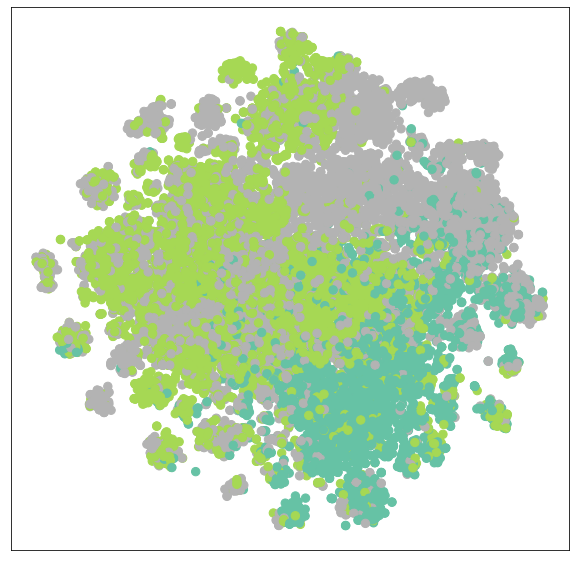

In [27]:
visualize(data.x, color=data.y)

In [28]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Net, self).__init__()

        self.conv1 = GATConv(in_channels, 8, heads=8, dropout=0.6)
        # On the Pubmed dataset, use heads=8 in conv2.
        self.conv2 = GATConv(8 * 8, out_channels, heads=8, concat=False,
                             dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(dataset.num_features, dataset.num_classes).to(device)
data = data.to(device)
labels = data.y.clone().detach().cpu()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [30]:
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return out

In [31]:
@torch.no_grad()
def test(data):
    model.eval()
    out, accs = model(data.x, data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
        accs.append(acc)
    return accs

In [32]:
for epoch in range(1, 201):
    out = train(data)
    train_acc, val_acc, test_acc = test(data)
    if epoch % 10 == 0:
        #visualize(out, color=labels)
        print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
          f'Test: {test_acc:.4f}')

Epoch: 010, Train: 0.9000, Val: 0.7040, Test: 0.6780
Epoch: 020, Train: 0.9000, Val: 0.7440, Test: 0.7050
Epoch: 030, Train: 0.9167, Val: 0.7320, Test: 0.7060
Epoch: 040, Train: 0.9333, Val: 0.7620, Test: 0.7240
Epoch: 050, Train: 0.9667, Val: 0.7800, Test: 0.7560
Epoch: 060, Train: 0.9667, Val: 0.7880, Test: 0.7590
Epoch: 070, Train: 0.9667, Val: 0.7960, Test: 0.7790
Epoch: 080, Train: 0.9833, Val: 0.8000, Test: 0.7800
Epoch: 090, Train: 0.9833, Val: 0.8000, Test: 0.7810
Epoch: 100, Train: 1.0000, Val: 0.8100, Test: 0.7840
Epoch: 110, Train: 1.0000, Val: 0.8060, Test: 0.7830
Epoch: 120, Train: 0.9833, Val: 0.7980, Test: 0.7850
Epoch: 130, Train: 1.0000, Val: 0.7960, Test: 0.7860
Epoch: 140, Train: 1.0000, Val: 0.8000, Test: 0.7860
Epoch: 150, Train: 0.9833, Val: 0.7940, Test: 0.7810
Epoch: 160, Train: 1.0000, Val: 0.7940, Test: 0.7830
Epoch: 170, Train: 1.0000, Val: 0.7900, Test: 0.7840
Epoch: 180, Train: 0.9833, Val: 0.8000, Test: 0.7840
Epoch: 190, Train: 1.0000, Val: 0.8020, Test: 

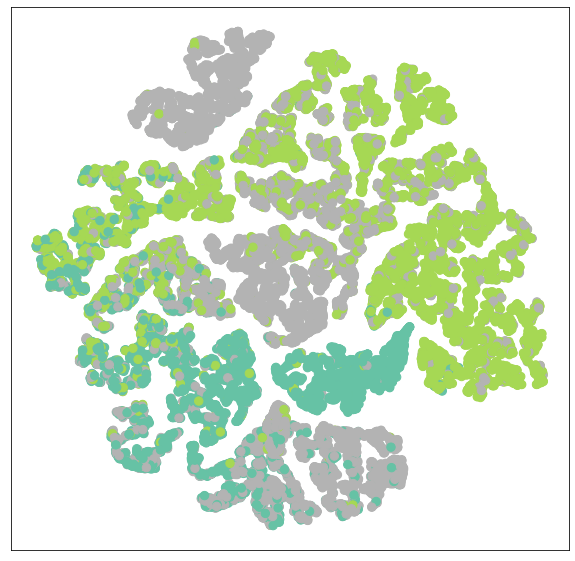

In [33]:
out = model(data.x, data.edge_index)
labels = data.y.clone().detach().cpu()
visualize(out, color=labels)